In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from math import sqrt

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import datetime

In [149]:
df = pd.read_csv('E:/HDD Documents/HDD Documents/School/WGU/d214_capstone/data/Warehouse_and_Retail_Sales.csv')

In [150]:
#Take a look at the data so we know what we're working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


In [151]:
#We don't need some of these columns
df = df.drop(columns = ['SUPPLIER', 'ITEM CODE', 'ITEM DESCRIPTION', 'RETAIL TRANSFERS'])

In [152]:
#Check missing data
df.isnull().any()

YEAR               False
MONTH              False
ITEM TYPE           True
RETAIL SALES        True
WAREHOUSE SALES    False
dtype: bool

In [153]:
#We're going to use ITEM_TYPE in our exploratory reporting but we don't want to add just any value, so we'll start there
#Look at column data to see how many values are missing and if we can replace them manually
df[df['ITEM TYPE'].isna()]

,YEAR,MONTH,ITEM TYPE,RETAIL SALES,WAREHOUSE SALES
107006,2017,10,NaN,0.0,1.0


In [154]:
#Research tells us that this is a WINE. Let's change it.
df['ITEM TYPE'].fillna('WINE', inplace = True)

In [155]:
#There is date information missing; we must correct this before we can continue
#Next, we'll add the date values

add_dates = [{'YEAR': '2018', 'MONTH' : '3'}, {'YEAR': '2018', 'MONTH' : '4'}, {'YEAR': '2018', 'MONTH' : '5'}, {'YEAR': '2018', 'MONTH' : '6'}, {'YEAR': '2018', 'MONTH' : '7'},
 {'YEAR': '2018', 'MONTH' : '8'}, {'YEAR': '2018', 'MONTH' : '9'}, {'YEAR': '2018', 'MONTH' : '10'}, {'YEAR': '2018', 'MONTH' : '11'}, {'YEAR': '2018', 'MONTH' : '12'},
 {'YEAR': '2020', 'MONTH' : '2'}, {'YEAR': '2020', 'MONTH' : '4'}, {'YEAR': '2020', 'MONTH' : '6'}, {'YEAR': '2020', 'MONTH' : '10'}, {'YEAR': '2020', 'MONTH' : '11'},
 {'YEAR': '2020', 'MONTH' : '9'}, {'YEAR': '2020', 'MONTH' : '5'}, {'YEAR': '2020', 'MONTH' : '8'}, {'YEAR': '2020', 'MONTH' : '12'}]

df = df.append(add_dates, ignore_index = True)

In [156]:
#We're going to use RETAIL_SALES so, we need to fill this data with the mean value for the column
df['RETAIL SALES'].fillna((df['RETAIL SALES'].mean()), inplace = True)
df['WAREHOUSE SALES'].fillna((df['WAREHOUSE SALES'].mean()), inplace = True)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307664 entries, 0 to 307663
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   YEAR             307664 non-null  object 
 1   MONTH            307664 non-null  object 
 2   ITEM TYPE        307645 non-null  object 
 3   RETAIL SALES     307664 non-null  float64
 4   WAREHOUSE SALES  307664 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.7+ MB


In [158]:
#The all-caps is annoying, let's change the columns we need and check for any leftover nulls
df = df.rename(columns = {'YEAR':'year', 'MONTH':'month', 'ITEM TYPE':'item_type', 'RETAIL SALES':'retail_sales', 'WAREHOUSE SALES':'warehouse_sales'})
df.head()

,year,month,item_type,retail_sales,warehouse_sales
0,2020,1,WINE,0.00,2.0
1,2020,1,WINE,0.00,4.0
2,2020,1,BEER,0.00,1.0
3,2020,1,WINE,0.00,1.0
4,2020,1,WINE,0.82,0.0


In [159]:
df['total_sales'] = df['retail_sales'] + df['warehouse_sales']

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307664 entries, 0 to 307663
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   year             307664 non-null  object 
 1   month            307664 non-null  object 
 2   item_type        307645 non-null  object 
 3   retail_sales     307664 non-null  float64
 4   warehouse_sales  307664 non-null  float64
 5   total_sales      307664 non-null  float64
dtypes: float64(3), object(3)
memory usage: 14.1+ MB


In [161]:
#We need a 'day' column for the time series. It's not in the data, so we'll set everything to 1
df['day'] = '1'

In [162]:
#Adding a proper date column for the time series analysis
df['date'] = pd.to_datetime(dict(year = df.year, month = df.month, day = df.day))

In [163]:
#Order the DataFrame by the new Date column
df = df.sort_values(['date'], ascending = True)

In [164]:
#Sanity check
df.head()

,year,month,item_type,retail_sales,warehouse_sales,total_sales,day,date
54813,2017,6,WINE,0.00,4.0,4.00,1,2017-06-01
51933,2017,6,WINE,0.00,1.0,1.00,1,2017-06-01
51932,2017,6,LIQUOR,9.33,5.0,14.33,1,2017-06-01
51931,2017,6,WINE,0.08,0.0,0.08,1,2017-06-01
51930,2017,6,LIQUOR,1.52,0.0,1.52,1,2017-06-01


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307664 entries, 54813 to 307663
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   year             307664 non-null  object        
 1   month            307664 non-null  object        
 2   item_type        307645 non-null  object        
 3   retail_sales     307664 non-null  float64       
 4   warehouse_sales  307664 non-null  float64       
 5   total_sales      307664 non-null  float64       
 6   day              307664 non-null  object        
 7   date             307664 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 21.1+ MB


In [166]:
#Save because we're going to make major changes to the DataFrame for visualization
df.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d214_capstone/data/Primary_df.csv')

In [167]:
#Rework DataFrame for visualizations
df = df[['year', 'item_type', 'total_sales']]

In [168]:
df = df[df['item_type'].notna()]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'WINE'),
  Text(1, 0, 'LIQUOR'),
  Text(2, 0, 'KEGS'),
  Text(3, 0, 'BEER'),
  Text(4, 0, 'NON-ALCOHOL'),
  Text(5, 0, 'DUNNAGE'),
  Text(6, 0, 'STR_SUPPLIES'),
  Text(7, 0, 'REF')])

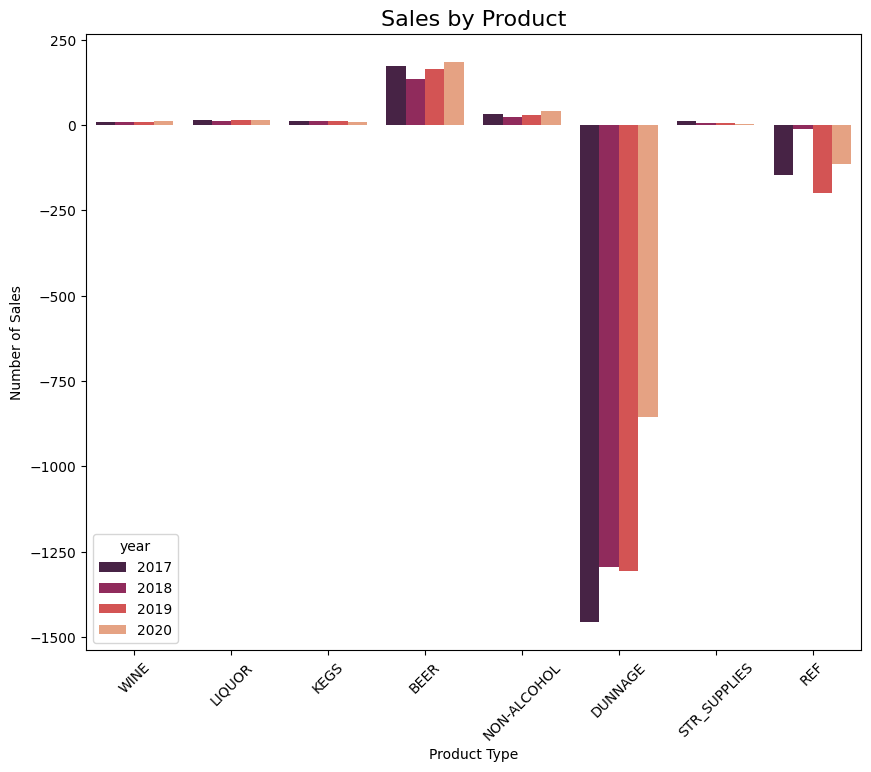

In [169]:
#Set seaborn plotting aesthetics
fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(x = 'item_type', y = 'total_sales', hue = 'year', data = df, palette = ("rocket"), errorbar = None)
plt.title('Sales by Product', fontsize = 16)
plt.xlabel('Product Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation = 45)

In [170]:
#Remove values that amount to cost, rather than sales
df = df[df.item_type != 'DUNNAGE']
df = df[df.item_type != 'REF']

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'WINE'),
  Text(1, 0, 'LIQUOR'),
  Text(2, 0, 'KEGS'),
  Text(3, 0, 'BEER'),
  Text(4, 0, 'NON-ALCOHOL'),
  Text(5, 0, 'STR_SUPPLIES')])

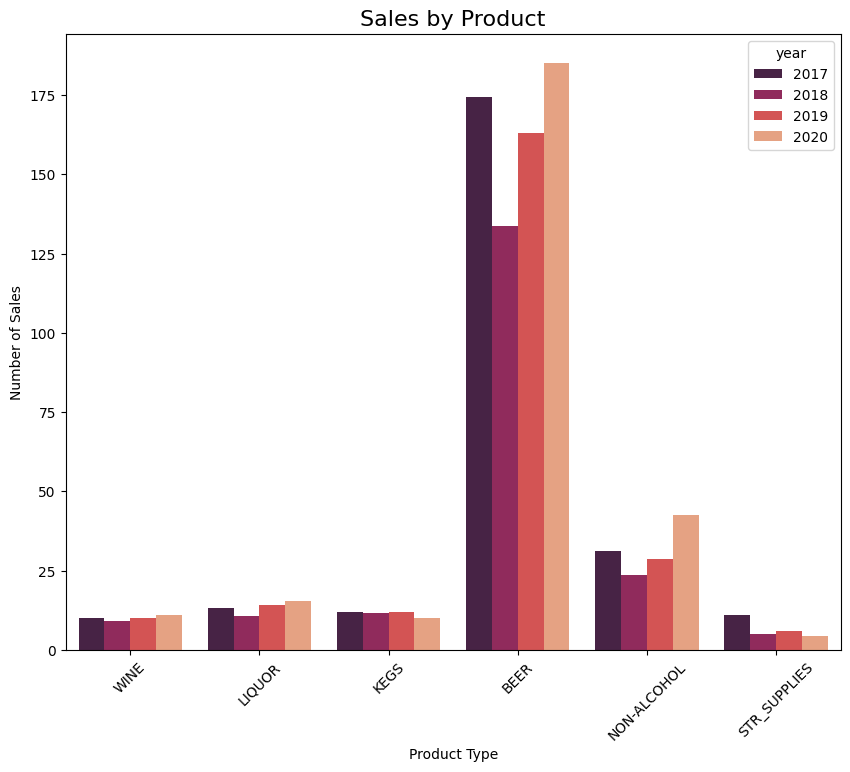

In [171]:
#Set seaborn plotting aesthetics
fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(x = 'item_type', y = 'total_sales', hue = 'year', data = df, palette = ("rocket"), errorbar = None)
plt.title('Sales by Product', fontsize = 16)
plt.xlabel('Product Type')
plt.ylabel('Number of Sales')
plt.xticks(rotation = 45)

In [172]:
df.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d214-capstone/data/Secondary_df.csv')

In [173]:
df = pd.read_csv('E:/HDD Documents/HDD Documents/School/WGU/d214-capstone/data/Primary_df.csv')

In [174]:
df.head()

,Unnamed: 0.1,Unnamed: 0,year,month,item_type,retail_sales,warehouse_sales,total_sales,day,date
0,0,54813,2017,6,WINE,0.00,4.0,4.00,1,2017-06-01
1,1,51933,2017,6,WINE,0.00,1.0,1.00,1,2017-06-01
2,2,51932,2017,6,LIQUOR,9.33,5.0,14.33,1,2017-06-01
3,3,51931,2017,6,WINE,0.08,0.0,0.08,1,2017-06-01
4,4,51930,2017,6,LIQUOR,1.52,0.0,1.52,1,2017-06-01


In [175]:
#Drop unnecessary columns
df = df[['total_sales', 'date']]
df

,total_sales,date
0,4.000,2017-06-01
1,1.000,2017-06-01
2,14.330,2017-06-01
3,0.080,2017-06-01
4,1.520,2017-06-01
...,...,...
307658,5.000,2020-09-01
307659,7.000,2020-09-01
307660,460772.950,2020-10-01
307661,412639.000,2020-11-01


In [176]:
#After the the dates are grouped to get rid of duplicates, we only have 43 entries
#This means the model will be more sensitive
print(df.info())
df = df.groupby('date').sum().round(2)
df = df.sort_index(ascending = True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307663 entries, 0 to 307662
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   total_sales  307663 non-null  float64
 1   date         307663 non-null  object 
dtypes: float64(1), object(1)
memory usage: 4.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-06-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total_sales  43 non-null     float64
dtypes: float64(1)
memory usage: 688.0+ bytes
None


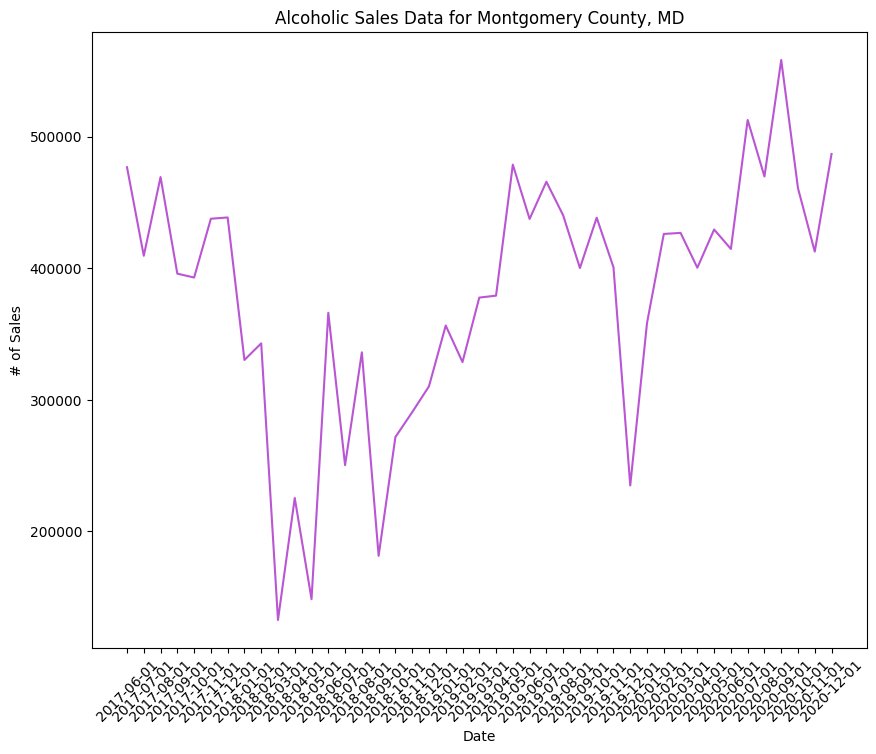

In [177]:
#Create visualization for DataFrame
index = df.index
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('# of Sales')
plt.title('Alcoholic Sales Data for Montgomery County, MD')
plt.plot(index, df.total_sales, color = 'mediumorchid')
plt.xticks(rotation = 45)
plt.show()

In [178]:
#Use ADF to assess whether dataset is stationary or non-stationary
#Since the p-value is not less than .05, we fail to reject the null hypothesis.
df_test = ts.adfuller(df['total_sales'], autolag = 'AIC')
df_op = pd.Series(df_test[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test[4].items():
    df_op['Critical Value (%s)'%key] = value
df_op

ADF Statistic           -1.706677
p-Value                  0.427676
Lags                     1.000000
Observations            41.000000
Critical Value (1%)     -3.600983
Critical Value (5%)     -2.935135
Critical Value (10%)    -2.605963
dtype: float64

In [179]:
df.head()

,total_sales
date,
2017-06-01,476748.09
2017-07-01,409478.58
2017-08-01,469298.47
2017-09-01,395893.13
2017-10-01,392951.87


In [180]:
#Transform dataset to stationary by using differencing (subtracting each point from the previous value).
df_stationary = df.diff(periods = 1, axis = 0).dropna()
print(df_stationary.info())
print(df_stationary.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 2017-07-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total_sales  42 non-null     float64
dtypes: float64(1)
memory usage: 672.0+ bytes
None
(42, 1)


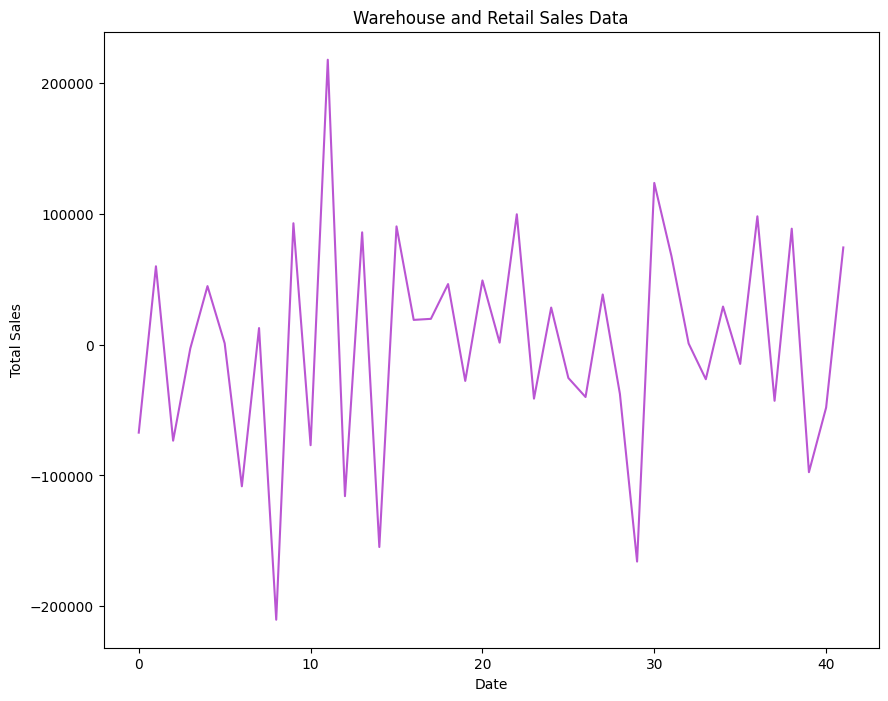

In [181]:
index2 = pd.Series(range(df_stationary.shape[0]))
fig, ax = plt.subplots(figsize = (10,8))

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Warehouse and Retail Sales Data')
plt.plot(index2, df_stationary.total_sales, color = 'mediumorchid')
plt.show()

In [182]:
#Use ADF to reassess whether updated dataset is stationary or non-stationary 
df_test2 = ts.adfuller(df_stationary['total_sales'], autolag = 'AIC')
df_op2 = pd.Series(df_test2[0:4], index = ['ADF Statistic', 'p-Value', 'Lags', 'Observations'])
for key, value in df_test2[4].items():
    df_op2['Critical Value (%s)'%key] = value
df_op2

ADF Statistic           -4.594161
p-Value                  0.000132
Lags                     2.000000
Observations            39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64

In [183]:
#Create Training and Test, keeping the recommended 4:1 ratio
test_size = int(.20 * df_stationary.shape[0])
train, test = train_test_split(df_stationary, test_size = test_size, shuffle = False, random_state = 22)

In [184]:
acf = acf((train['total_sales'].values))
acf_df = pd.DataFrame([acf]).T
acf_df.columns = ['ACF']

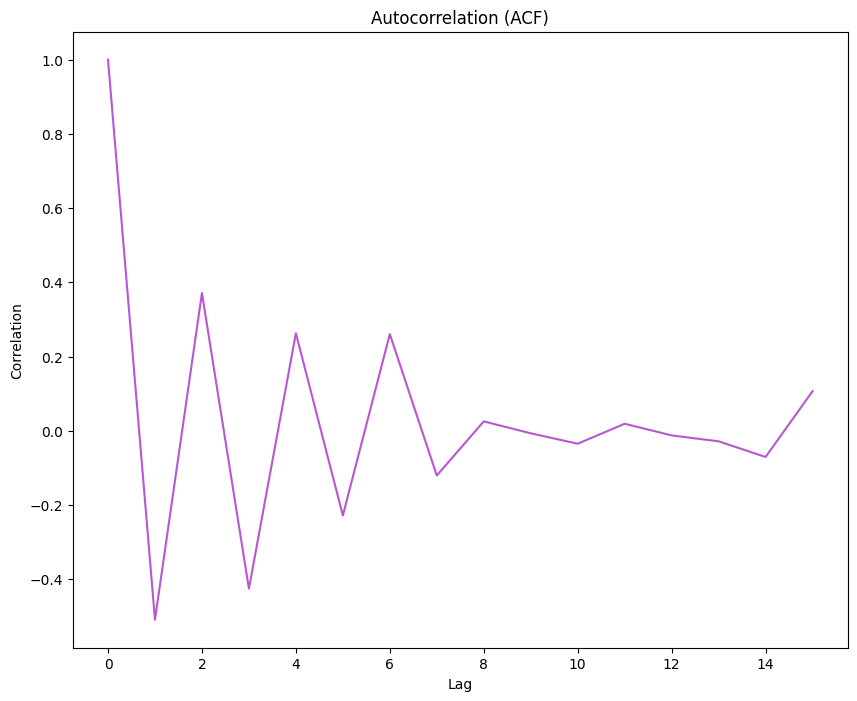

In [185]:
#ACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(acf_df.ACF, 'mediumorchid')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Autocorrelation (ACF)')
plt.show()

In [186]:
pacf = pacf((train['total_sales'].values))
pacf_df = pd.DataFrame([pacf]).T
pacf_df.columns = ['PACF']

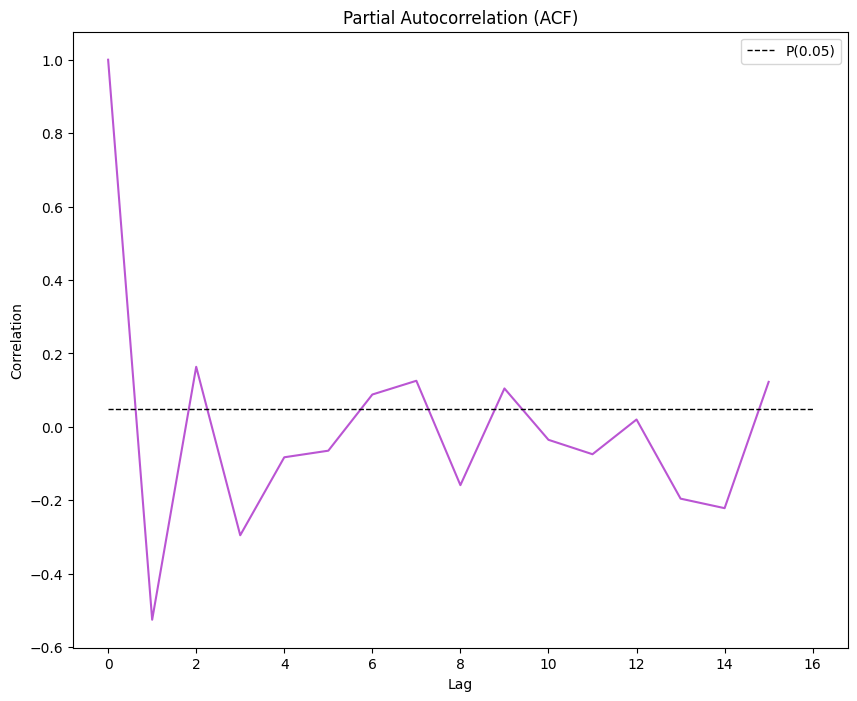

In [187]:
#PACF Visualization
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(pacf_df.PACF, 'mediumorchid')
ax.hlines(y = 0.05, xmin = 0, xmax = len(pacf), lw = 1, linestyles = '--', color = 'black', label = 'P(0.05)')
ax.legend()
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation (ACF)')
plt.show()

In [188]:
df.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d214-capstone/data/Tertiary_df.csv')

In [189]:
df_stationary.to_csv('E:/HDD Documents/HDD Documents/School/WGU/d214-capstone/data/Stationary_df.csv')

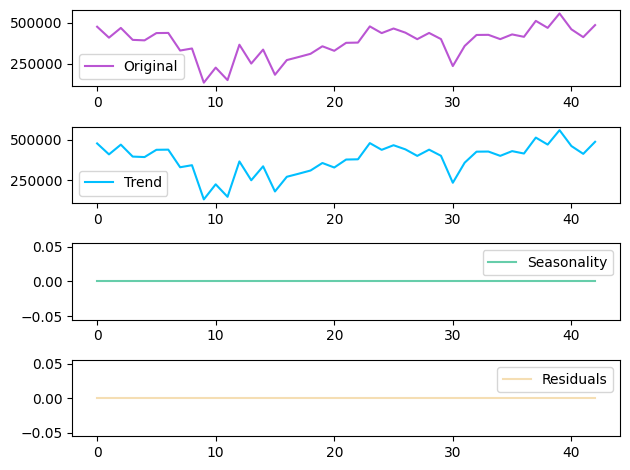

In [190]:
#Use seasonal_decompose to plot decomposition values
decomposition = seasonal_decompose(df['total_sales'].values, model = 'additive', period = 1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(df['total_sales'].values, label = 'Original', color = 'mediumorchid')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'deepskyblue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality', color = 'mediumaquamarine')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label = 'Residuals', color = 'wheat')
plt.legend(loc= 'best')
plt.tight_layout()

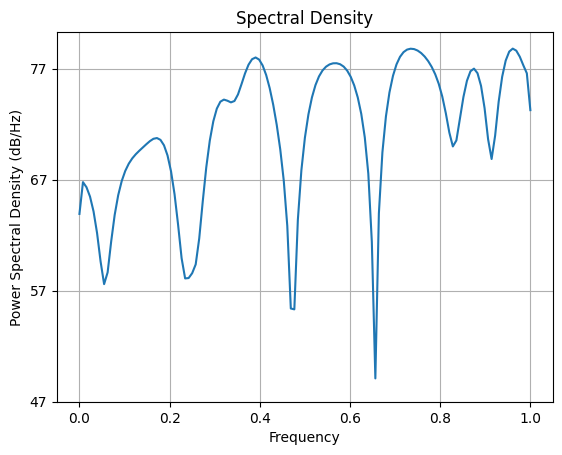

In [191]:
#Create a spectral density visualization
plt.psd(df_stationary['total_sales'])
plt.title('Spectral Density')
plt.show()

In [192]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [193]:
stepwise_fit = auto_arima(df['total_sales'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1091.016, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1111.779, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1094.260, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1105.847, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1231.374, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1091.692, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1088.974, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1093.148, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1088.892, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1088.994, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1090.845, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.359 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   43
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -540.446
Date:                Tue, 27 Dec 2022   AIC                           1088.892
Time:                        16:41:46   BIC                           1095.937
Sample:                    06-01-2017   HQIC                          1091.490
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.579e+04   4.62e+04      1.855      0.064   -4831.720    1.76e+05
ar.L1          0.3731      0.194      1.927      0.054      -0.006       0.753
ar.L2          0.4089      0.168      2.434      0.015       0.080       0.738
sigma2      4.846e+09      0.123   3.93e+10      0.000    4.85e+09    4.85e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 9.31
Prob(Q):                              0.62   Prob(JB):                         0.01
Heteroskedasticity (H):               0.77   Skew:                            -0.87
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.36e+31. Standard errors may be unstable.
"""

In [194]:
model = ARIMA(df['total_sales'], order = (2,0,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_sales   No. Observations:                   43
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -540.497
Date:                Tue, 27 Dec 2022   AIC                           1088.995
Time:                        16:41:47   BIC                           1096.039
Sample:                    06-01-2017   HQIC                          1091.592
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.791e+05   4.21e+04      9.002      0.000    2.97e+05    4.62e+05
ar.L1          0.3634      0.194      1.870      0.062      -0.018       0.744
ar.L2          0.3981      0.169      2.362      0.018       0.068       0.728
sigma2      4.846e+09      0.943   5.14e+09      0.000    4.85e+09    4.85e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 9.38
Prob(Q):                              0.59   Prob(JB):                         0.01
Heteroskedasticity (H):               0.78   Skew:                            -0.88
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.99e+24. Standard errors may be unstable.
"""

In [195]:
print(df.shape)
train = df.iloc[:-9]
test = df.iloc[-9:]
print(train.shape, test.shape)

(43, 1)
(34, 1) (9, 1)


In [196]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start = start, end = end,typ = 'levels').rename('Predictions')
print(pred)

pred.index = df.index[start:end + 1]

2020-04-01    415159.449818
2020-05-01    405858.308924
2020-06-01    405874.825000
2020-07-01    412068.879006
2020-08-01    441794.475385
2020-09-01    465198.397639
2020-10-01    480275.492337
2020-11-01    480107.087925
2020-12-01    423808.341339
Freq: MS, Name: Predictions, dtype: float64


In [197]:
model2 = ARIMA(df['total_sales'], order = (2, 0, 0))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_sales   No. Observations:                   43
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -540.497
Date:                Tue, 27 Dec 2022   AIC                           1088.995
Time:                        16:41:47   BIC                           1096.039
Sample:                    06-01-2017   HQIC                          1091.592
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.791e+05   4.21e+04      9.002      0.000    2.97e+05    4.62e+05
ar.L1          0.3634      0.194      1.870      0.062      -0.018       0.744
ar.L2          0.3981      0.169      2.362      0.018       0.068       0.728
sigma2      4.846e+09      0.943   5.14e+09      0.000    4.85e+09    4.85e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 9.38
Prob(Q):                              0.59   Prob(JB):                         0.01
Heteroskedasticity (H):               0.78   Skew:                            -0.88
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.99e+24. Standard errors may be unstable.
"""

In [198]:
index_future_dates = pd.date_range(start='2020-12-1', end = '2021-04-1', freq='M')
print(index_future_dates)
results = model.predict(start = len(train), end = len(train) + 3, typ ='levels').rename('Quarterly Predictions, Monthly')
results.index = index_future_dates
results

DatetimeIndex(['2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31'], dtype='datetime64[ns]', freq='M')


2020-12-31    415159.449818
2021-01-31    405858.308924
2021-02-28    405874.825000
2021-03-31    412068.879006
Freq: M, Name: Quarterly Predictions, Monthly, dtype: float64

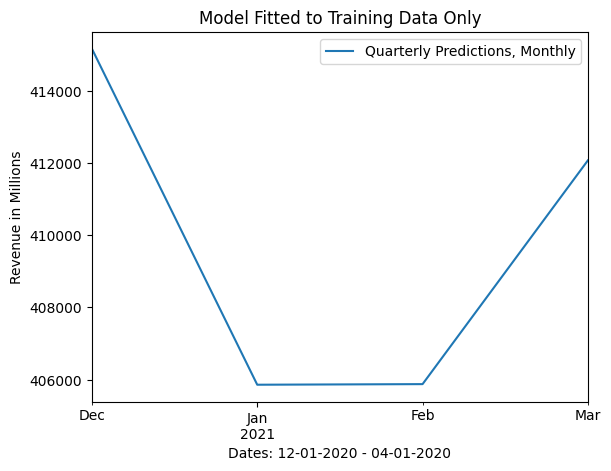

In [204]:
results.plot(legend = True)
plt.xlabel('Dates: 12-01-2020 - 04-01-2020')
plt.ylabel('Revenue in Millions')
plt.title('Model Fitted to Training Data Only')
plt.show()

In [215]:
expected = test
predictions = pred
f = df['total_sales']

In [216]:
mse = mean_squared_error(expected, predictions)
print('MSE: %f' % mse)

MSE: 3257023184.004864


In [217]:
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 57070.335412


In [222]:
forecast_errors = [pred[i]-f[i] for i in range(len(pred))]
print('Forecast Errors: %s' % forecast_errors)

Forecast Errors: [-61588.64018245763, -3620.2710761743947, -63423.64500015555, 16175.749005686434, 48842.60538466292, 27576.54763943446, 41683.782337042154, 149797.64792528655, 80879.69133917528]
